In [233]:
%matplotlib inline
import matplotlib.pyplot as plt

import gc
import time
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from time import gmtime, strftime

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import scipy
import gc
import sys

#Add https://www.kaggle.com/anttip/wordbatch to your kernel Data Sources, 
#until Kaggle admins fix the wordbatch pip package installation
# sys.path.insert(0, '../input/wordbatch/wordbatch/')
##import wordbatch
##from wordbatch.extractors import WordBag, WordHash
##from wordbatch.models import FTRL, FM_FTRL

from nltk.corpus import stopwords
import re

def rmsle(y, y_pred):
     assert len(y) == len(y_pred)
     y = np.array(y)
     y_pred = np.array(y_pred)
     y_pred[y_pred<0] = 0
     y[y<0] = 0   
     
     return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))
    

In [361]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflow'

In [184]:
NUM_BRANDS = 4500
NUM_CATEGORIES = 1250

develop = False
# develop= True

start_time = time.time()
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

2018-02-05 10:48:33


In [185]:
LOAD_TEST = False
MAKE_SAMPLE = True

train = pd.read_table('input/train.tsv', engine='c')
if MAKE_SAMPLE:
    train = train.sample(n=100000).reset_index().drop('index',axis=1).copy(deep=True)
 

print('Train shape: ', train.shape)
merged = pd.concat([train])
nrow_train = train.shape[0]
del train


if LOAD_TEST:
    test = pd.read_table('input/test.tsv', engine='c')
    if MAKE_SAMPLE:
        test = test.sample(n=100000).reset_index().drop('index',axis=1).copy(deep=True)
    
    print('Test shape: ', test.shape)
    merged = pd.concat([merged, test])
    nrow_test = test.shape[0]
    del test
    
print('Merged shape: ', merged.shape)

merged.head()

Train shape:  (100000, 8)
Merged shape:  (100000, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,854,Breville Juice Power Elite,3,Home/Home Appliances/Kitchen Appliances,Breville,115.0,0,"Super powerful, commercial grade juicer. Paid ..."
1,162529,Nwt Bubba Gump Forrest Gump Sticker,1,Handmade/Paper Goods/Sticker,NaN,3.0,1,Nwt Bubba Gump Forrest Gump Sticker. Got this ...
2,179719,Instax Mini 8 Case - White,1,Electronics/Cameras & Photography/Camera & Pho...,Fuji,26.0,1,New in box!
3,123465,Girls Nike and Under Armour Outfit,3,Kids/Girls (4+)/Tops & T-Shirts,Nike,16.0,0,In good condition Girls Outfit Nike Dri Fit Sh...
4,139612,5 children's learning games,3,Kids/Toys/Learning & Education,NaN,22.0,0,5 learning children's ages 3+ selling as a lot...


In [186]:
## count non-utf characters
s = "☆Please read bio☆ Women's sandal bundle"
def count_nonutf(s):
    s_clean = re.sub(r'[^\x00-\x7F]+','', s)
    return len(s)-len(s_clean)


tt = pd.DataFrame([ count_nonutf(x) for x in merged['item_description']])
merged['non_utf_descr'] = tt

tt = pd.DataFrame([ count_nonutf(x) for x in merged['name']])
merged['non_utf_name'] = tt

In [236]:
## Building features with counts of all Non-utf symbols
##
s = "☆Please read bio☆ Women's sandal bundle"

def all_non_utf(s):
    s_clean = re.sub(r'[\x00-\x7F]','', s)
    char_dict = dict()
    for k in s_clean:
        if k not in char_dict.keys():
            char_dict[k]=s_clean.count(k)
    return char_dict

print ("Counting non utf symbols")
tt = pd.DataFrame([ all_non_utf(x) for x in merged['item_description']])
tt.fillna(0,inplace=True)

print ("Converting to sparse")
X_non_utf_uniq = scipy.sparse.csr_matrix(X_uniq)

print ("Doing svd")
svd = TruncatedSVD(n_components = 10)
X_non_utf_uniq = svd.fit_transform(X_non_utf_uniq)
X_non_utf_uniq = pd.DataFrame(X_non_utf_uniq)

In [342]:
ss = "!!sdfdsf"
s_clean = re.sub('[^! ]+','', ss)
s_clean

'!!'

In [344]:
## Count number of letters in upper case
##
def perc_symbols(s,pattern):
    try:
        s_clean = re.sub(pattern,'', s)
        return len(s_clean)/len(s)
    except:
        return 0

def count_symbols(s, pattern):
    try:
        s_clean = re.sub(pattern,'', s)
        return len(s_clean)
    except:
        return 0
    
## upper case
##
tt = pd.DataFrame([perc_symbols(x,r'[^A-Z ]+') for x in merged['item_description']])
merged['upper_perc_descr'] = tt

tt = pd.DataFrame([perc_symbols(x,r'[^A-Z ]+') for x in merged['name']])
merged['upper_perc_name'] = tt

tt = pd.DataFrame([count_symbols(x,r'[^A-Z ]+') for x in merged['item_description']])
merged['count_upper_descr'] = tt

tt = pd.DataFrame([count_symbols(x,r'[^A-Z ]+') for x in merged['name']])
merged['count_upper_name'] = tt

## exclamation points
tt = pd.DataFrame([perc_symbols(x,r'[^!]+') for x in merged['item_description']])
merged['upper_perc_excl'] = tt

tt = pd.DataFrame([count_symbols(x,r'[^!]+') for x in merged['item_description']])
merged['count_upper_excl'] = tt

In [262]:
## length of description and brand name
tt = pd.DataFrame([len(x) for x in merged['item_description']])
merged['len_descr'] = tt

tt = pd.DataFrame([len(x) for x in merged['name']])
merged['len_name'] = tt

In [293]:
merged.loc[1,'item_description']

'Nwt Bubba Gump Forrest Gump Sticker. Got this at the Bubba Gump Restaurant in Denver Colorado.'

In [318]:
def search_in_str(s,string_val):
    instr = re.findall(string_val,s,flags=re.IGNORECASE)
    if len(instr)>0:
        return 1
    else:
        return 0

def search_in_merged(string_val):
    tt1 = ([search_in_str(x,string_val) for x in merged['item_description']])
    tt2 = ([search_in_str(x,string_val) for x in merged['name']])
    tt =  pd.DataFrame({'tt1':tt1,'tt2':tt2}).max(axis=1)
    return tt

merged['a_free'] = search_in_merged('Free')
merged['a_free_ship'] = search_in_merged('Free ship')
merged['a_new'] = search_in_merged('new')
merged['a_sale'] = search_in_merged('sale')
merged['a_gift'] = search_in_merged('gift')
merged['a_nwt'] = search_in_merged('nwt')
merged['a_100perc'] = search_in_merged('100%')

In [319]:
merged.sample(10)[['name','brand_name','item_description','a_free','a_free_ship','a_new','a_sale','a_gift','a_nwt','a_100perc']]

,name,brand_name,item_description,a_free,a_free_ship,a_new,a_sale,a_gift,a_nwt,a_100perc
12851,Women's Under Armour Tank,Under Armour,New with tags! Size small. Bright orange color...,0,0,1,0,0,0,0
488,Black Butter Slime,missing,This slime spreads very good. It includes a 2 ...,0,0,0,0,0,0,0
7159,For Penelope,PANDORA,One Disney pandora charm.,0,0,0,0,0,0,0
63466,Eight crazy nights Adam sanders,missing,Plays great,0,0,0,0,0,0,0
87108,A&F jeans for Parris Bradford,Abercrombie & Fitch,No description yet,0,0,0,0,0,0,0
26045,Victoria Secret Pantie ( Medium ),Victoria's Secret,Brand New,0,0,1,0,0,0,0
85924,Alex and ani - lotus peace petals,ALEX AND ANI,Brand new been worn!,0,0,1,0,0,0,0
44024,Vera Bradley Lunchbox,Vera Bradley,"Vera Bradley Lunchbox, some marks inside but s...",0,0,0,0,0,0,0
27145,⚡️FS Kylie Dolce K and Candy K Minis,missing,FOR DOLCE K AND CANDY K MINIS ONLY PRICE FIRM ...,0,0,0,0,0,0,1
18348,Life proof iPhone 6,missing,Teal and white lifeproof.,0,0,0,0,0,0,0


In [276]:
## preprocess - splitting category names
##

tt = pd.DataFrame([ str(x).split("/") for x in merged['category_name']])
cat_col_names = ['general_cat','subcat_1','subcat_2','subcat_3','subcat_4']
tt.columns = ['general_cat','subcat_1','subcat_2','subcat_3','subcat_4']

merged[cat_col_names] = tt
merged["category_name"] = merged["category_name"].fillna("Other").astype("category")

## merged.drop('category_name', axis=1, inplace=True)
del tt


In [254]:
## replace missing values
for col_name in  cat_col_names+['brand_name']+['item_description']:
    merged['mis_'+col_name] = 0
    merged[col_name].fillna(value='missing', inplace=True)
    merged.loc[merged[col_name]=='missing','mis_'+col_name] = 1

merged.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,non_utf_descr,non_utf_name,...,subcat_2,subcat_3,subcat_4,mis_general_cat,mis_subcat_1,mis_subcat_2,mis_subcat_3,mis_subcat_4,mis_brand_name,mis_item_description
0,854,Breville Juice Power Elite,3,Home/Home Appliances/Kitchen Appliances,missing,115.0,0,"Super powerful, commercial grade juicer. Paid ...",0,0,...,Kitchen Appliances,missing,missing,0,0,0,1,1,1,0
1,162529,Nwt Bubba Gump Forrest Gump Sticker,1,Handmade/Paper Goods/Sticker,missing,3.0,1,Nwt Bubba Gump Forrest Gump Sticker. Got this ...,0,0,...,Sticker,missing,missing,0,0,0,1,1,1,0
2,179719,Instax Mini 8 Case - White,1,Electronics/Cameras & Photography/Camera & Pho...,Fuji,26.0,1,New in box!,0,0,...,Camera & Photo Accessories,missing,missing,0,0,0,1,1,0,0
3,123465,Girls Nike and Under Armour Outfit,3,Kids/Girls (4+)/Tops & T-Shirts,Nike,16.0,0,In good condition Girls Outfit Nike Dri Fit Sh...,0,0,...,Tops & T-Shirts,missing,missing,0,0,0,1,1,0,0
4,139612,5 children's learning games,3,Kids/Toys/Learning & Education,missing,22.0,0,5 learning children's ages 3+ selling as a lot...,0,0,...,Learning & Education,missing,missing,0,0,0,1,1,1,0


In [192]:
VAL_MISS_MARGIN = 10

### delete rare brands
##

pop_brand = merged['brand_name'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
merged.loc[merged['brand_name'].isin(pop_brand), 'mis_brand_name'] = 1
merged.loc[merged['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'

## delete rare categories
##

pop_category1 = merged['general_cat'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
pop_category2 = merged['subcat_1'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
pop_category3 = merged['subcat_2'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
# merged.loc[merged['general_cat'].isin(pop_brand), 'mis_general_cat'] = 1
# merged.loc[merged['general_cat'].isin(pop_category1), 'general_cat'] = 'missing'
# merged.loc[merged['subcat_1'].isin(pop_brand), 'mis_subcat_1'] = 1
# merged.loc[merged['subcat_1'].isin(pop_category2), 'subcat_1'] = 'missing'
# merged.loc[merged['subcat_2'].isin(pop_brand), 'mis_subcat_2'] = 1
# merged.loc[merged['subcat_2'].isin(pop_category3), 'subcat_2'] = 'missing'
    
print (pop_brand)
print (len(pop_category1),pop_category1[1:5])
print (len(pop_category2),pop_category2[1:5])
print (len(pop_category3),pop_category3[1:5])

['Lansinoh' 'Casio' 'Avenue' ..., 'Comic Images' 'Jason Maxwell'
 'Buffalo Jeans']
0 []
14 ['Knitting' 'Potty Training' 'Furniture' 'Suits']
288 ['Paintings' 'Camcorders' 'Volleyball' 'Outdoor']


In [204]:
X_name


<100000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 425283 stored elements in Compressed Sparse Row format>

In [260]:
NAME_MIN_DF = 10 ## lower bound for word count
MAX_FEAT_DESCP = 5000

print("Name Encodings")

##count = CountVectorizer(min_df=NAME_MIN_DF)
##X_name = count.fit_transform(merged["name"])

count_descp = TfidfVectorizer(max_features = MAX_FEAT_DESCP, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_name = count_descp.fit_transform(merged["name"])


print("Category Encoders")
count_category = CountVectorizer()
X_category = count_category.fit_transform(merged["category_name"])
X_gen_cat = count_category.fit_transform(merged["general_cat"])
X_cat1 = count_category.fit_transform(merged["subcat_1"])
X_cat2 = count_category.fit_transform(merged["subcat_2"])
X_cat3 = count_category.fit_transform(merged["subcat_3"])


print("Descp encoders")
count_descp = TfidfVectorizer(max_features = MAX_FEAT_DESCP, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_descp = count_descp.fit_transform(merged["item_description"])

print("Brand encoders")
vect_brand = LabelBinarizer(sparse_output=True)
X_brand = vect_brand.fit_transform(merged["brand_name"])

print("Dummy Encoders")
merged['item_condition_id'] = merged['item_condition_id'].astype('category')
merged['shipping'] = merged['shipping'].astype('category')
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(merged[["item_condition_id", "shipping"]], sparse = True).values)



Name Encodings
Category Encoders
Descp encoders
Brand encoders
Dummy Encoders


In [360]:
merged['shipping'].unique()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,non_utf_descr,non_utf_name,...,mis_item_description,a_free,a_free_ship,a_new,a_sale,a_gift,a_nwt,a_100perc,upper_perc_excl,count_upper_excl
0,854,Breville Juice Power Elite,3,Home/Home Appliances/Kitchen Appliances,missing,115.0,0,"Super powerful, commercial grade juicer. Paid ...",0,0,...,0,0,0,0,1,0,0,0,0.000000,0
1,162529,Nwt Bubba Gump Forrest Gump Sticker,1,Handmade/Paper Goods/Sticker,missing,3.0,1,Nwt Bubba Gump Forrest Gump Sticker. Got this ...,0,0,...,0,0,0,0,0,0,1,0,0.000000,0
2,179719,Instax Mini 8 Case - White,1,Electronics/Cameras & Photography/Camera & Pho...,Fuji,26.0,1,New in box!,0,0,...,0,0,0,1,0,0,0,0,0.090909,1
3,123465,Girls Nike and Under Armour Outfit,3,Kids/Girls (4+)/Tops & T-Shirts,Nike,16.0,0,In good condition Girls Outfit Nike Dri Fit Sh...,0,0,...,0,1,0,0,0,0,0,0,0.000000,0
4,139612,5 children's learning games,3,Kids/Toys/Learning & Education,missing,22.0,0,5 learning children's ages 3+ selling as a lot...,0,0,...,0,0,0,0,0,0,0,0,0.000000,0
5,508158,Aztec Secret Indian Healing Clay,2,Beauty/Skin Care/Face,missing,14.0,0,"Indian healing clay Used twice, doesnt work fo...",0,0,...,0,0,0,0,0,0,0,0,0.000000,0
6,303386,Under Armour Shoes,2,Women/Shoes/Athletic,Under Armour,20.0,1,"Only worn a few times, great condition!",0,0,...,0,0,0,0,0,0,0,0,0.025641,1
7,456804,HOODED FLANNEL WET SEAL,3,Women/Tops & Blouses/Button Down Shirt,Wet Seal,8.0,0,"Small Wet Seal Hooded Flannel Blue, Red, and W...",0,0,...,0,1,1,0,0,0,0,0,0.000000,0
8,386997,Anthropologie statement necklace,2,Women/Jewelry/Necklaces,Anthropologie,12.0,0,"Never been worn, awesome statement necklace fr...",0,0,...,0,0,0,0,0,0,0,0,0.000000,0
9,1711,BBW Paris Amour edp,3,Beauty/Fragrance/Women,Bath & Body Works,16.0,1,A little is used. This is the eau de parfum wh...,0,0,...,0,0,0,0,0,0,0,0,0.000000,0


In [352]:
X = scipy.sparse.hstack((X_dummies, 
                         X_descp,
                         X_brand,
                         X_gen_cat, X_cat1, X_cat2, X_cat3,
                         X_name
                        ,merged[['mis_general_cat','mis_subcat_1','mis_subcat_2','mis_subcat_3','mis_subcat_4','mis_brand_name','mis_item_description']]
                        ,merged[['non_utf_descr','non_utf_name','upper_perc_descr','upper_perc_name']]
                        ,X_non_utf_uniq
                        ,merged[['a_free','a_free_ship','a_new','a_sale','a_gift','a_nwt','a_100perc']]
                        ,merged[['count_upper_excl']]
                        )).tocsr()
print (X.shape)
## del X_dummies, X_descp, X_brand,X_category,X_name, X_gen_cat, X_cat1, X_cat2, X_cat3
gc.collect()

## 'count_upper_descr','count_upper_name','len_descr','len_name'

(100000, 11457)


57

In [226]:
## save data
##
scipy.sparse.save_npz('model/x.npz',X)
merged.to_csv('model/merged.csv',encoding='utf-8')

In [155]:
## load data
##

X = scipy.sparse.load_npz('model/x.npz')
merged = pd.read_csv('model/merged.csv')


In [329]:
train_test_split??

In [353]:
y_merged_train = merged['price'][:nrow_train]
y_merged_train = np.log1p(y_merged_train)
X_merged_train = X[:nrow_train]

X_train, X_valid, y_train, y_valid = train_test_split(X_merged_train, y_merged_train, test_size=0.2, random_state =102)
k_fold = KFold(n_splits=5,random_state=101)


print (X_train.shape, len(y_train))
print (X_valid.shape, len(y_valid))


(80000, 11457) 80000
(20000, 11457) 20000


In [354]:
## https://www.kaggle.com/apapiu/ridge-script
##

## scorer_func = make_scorer(rmsle,greater_is_better=False)
## scorer_func = make_scorer(r2_score,greater_is_better=True)
scorer_func = make_scorer(mean_squared_error,greater_is_better=False)
## scorer_func = make_scorer(mean_squared_log_error,greater_is_better=False)

mm = Ridge(solver = "lsqr", normalize=False, fit_intercept=False,random_state=120)

scores = cross_val_score(mm, X_train, y_train, 
                         cv=k_fold, n_jobs=-1,scoring = scorer_func)

scores = np.sqrt(-scores)
print (np.mean(scores),scores)

## test on validation
mm.fit(X_train, y_train)
y_pred = mm.predict(X_valid)
y_pred[y_pred<1.386]=1.386

print ("RMSLE: ",rmsle(np.expm1(y_valid),np.expm1(y_pred)))
print ("RMSE: ",mean_squared_error(y_valid,y_pred))
print ("R2: ",r2_score(y_valid,y_pred))

0.518063206726 [ 0.52238757  0.51794012  0.52194165  0.51451337  0.51353333]
RMSLE:  0.512900515774
RMSE:  0.263066939082
R2:  0.521883658552


In [ ]:
0.518020633601 [ 0.52231744  0.5173286   0.52197693  0.51487274  0.51360746]
RMSLE:  0.51304258507
RMSE:  0.263212694095
R2:  0.521618753148

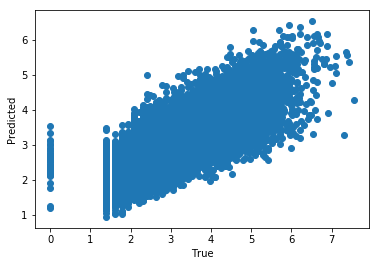

In [44]:
y_pred = mm.predict(X_train)

plt.scatter(y_train,y_pred)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

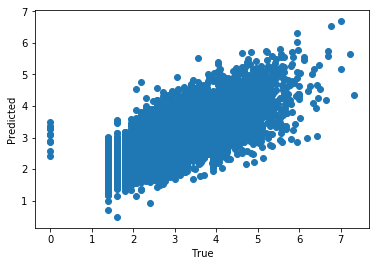

In [45]:
y_pred = mm.predict(X_valid)

plt.scatter(y_valid,y_pred)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [25]:
min(y_valid[y_valid>0])

1.3862943611198906

In [358]:
params2 = {
        'learning_rate': 0.1,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 120,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 2,
        'bagging_fraction': 1,
        'nthread': 4
}

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)


watchlist2 = [d_valid]    
model = lgb.train(params2, train_set=d_train, num_boost_round=8000, valid_sets=watchlist2, \
    early_stopping_rounds=250, verbose_eval=True)     

y_pred = model.predict(X_valid)
y_pred[y_pred<1.386]=1.386

print ("RMSLE: ",rmsle(np.expm1(y_valid),np.expm1(y_pred)))
print ("RMSE: ",mean_squared_error(y_valid,y_pred))
print ("R2: ",r2_score(y_valid,y_pred))


[1]	valid_0's rmse: 0.733045
Training until validation scores don't improve for 250 rounds.
[2]	valid_0's rmse: 0.725749
[3]	valid_0's rmse: 0.719504
[4]	valid_0's rmse: 0.713789
[5]	valid_0's rmse: 0.708098
[6]	valid_0's rmse: 0.703949
[7]	valid_0's rmse: 0.699604
[8]	valid_0's rmse: 0.695776
[9]	valid_0's rmse: 0.692348
[10]	valid_0's rmse: 0.688994
[11]	valid_0's rmse: 0.686058
[12]	valid_0's rmse: 0.683651
[13]	valid_0's rmse: 0.681227
[14]	valid_0's rmse: 0.678609
[15]	valid_0's rmse: 0.676097
[16]	valid_0's rmse: 0.673939
[17]	valid_0's rmse: 0.672271
[18]	valid_0's rmse: 0.670122
[19]	valid_0's rmse: 0.668759
[20]	valid_0's rmse: 0.667254
[21]	valid_0's rmse: 0.66571
[22]	valid_0's rmse: 0.664345
[23]	valid_0's rmse: 0.662789
[24]	valid_0's rmse: 0.661482
[25]	valid_0's rmse: 0.659901
[26]	valid_0's rmse: 0.658103
[27]	valid_0's rmse: 0.657136
[28]	valid_0's rmse: 0.656108
[29]	valid_0's rmse: 0.654557
[30]	valid_0's rmse: 0.653395
[31]	valid_0's rmse: 0.651724
[32]	valid_0's rm

[272]	valid_0's rmse: 0.576766
[273]	valid_0's rmse: 0.576699
[274]	valid_0's rmse: 0.576576
[275]	valid_0's rmse: 0.576423
[276]	valid_0's rmse: 0.576343
[277]	valid_0's rmse: 0.576234
[278]	valid_0's rmse: 0.576176
[279]	valid_0's rmse: 0.576064
[280]	valid_0's rmse: 0.57593
[281]	valid_0's rmse: 0.575805
[282]	valid_0's rmse: 0.575692
[283]	valid_0's rmse: 0.575598
[284]	valid_0's rmse: 0.575486
[285]	valid_0's rmse: 0.575398
[286]	valid_0's rmse: 0.575262
[287]	valid_0's rmse: 0.575145
[288]	valid_0's rmse: 0.575028
[289]	valid_0's rmse: 0.57492
[290]	valid_0's rmse: 0.57482
[291]	valid_0's rmse: 0.574753
[292]	valid_0's rmse: 0.574656
[293]	valid_0's rmse: 0.57455
[294]	valid_0's rmse: 0.574438
[295]	valid_0's rmse: 0.57432
[296]	valid_0's rmse: 0.574247
[297]	valid_0's rmse: 0.574068
[298]	valid_0's rmse: 0.573929
[299]	valid_0's rmse: 0.573789
[300]	valid_0's rmse: 0.573662
[301]	valid_0's rmse: 0.57353
[302]	valid_0's rmse: 0.573405
[303]	valid_0's rmse: 0.573312
[304]	valid_0'

[538]	valid_0's rmse: 0.554498
[539]	valid_0's rmse: 0.554437
[540]	valid_0's rmse: 0.554385
[541]	valid_0's rmse: 0.554311
[542]	valid_0's rmse: 0.554288
[543]	valid_0's rmse: 0.554255
[544]	valid_0's rmse: 0.554147
[545]	valid_0's rmse: 0.554032
[546]	valid_0's rmse: 0.553977
[547]	valid_0's rmse: 0.553898
[548]	valid_0's rmse: 0.553887
[549]	valid_0's rmse: 0.553831
[550]	valid_0's rmse: 0.553779
[551]	valid_0's rmse: 0.55369
[552]	valid_0's rmse: 0.553654
[553]	valid_0's rmse: 0.553587
[554]	valid_0's rmse: 0.553553
[555]	valid_0's rmse: 0.553511
[556]	valid_0's rmse: 0.553455
[557]	valid_0's rmse: 0.553418
[558]	valid_0's rmse: 0.553361
[559]	valid_0's rmse: 0.553312
[560]	valid_0's rmse: 0.553244
[561]	valid_0's rmse: 0.553168
[562]	valid_0's rmse: 0.553136
[563]	valid_0's rmse: 0.553022
[564]	valid_0's rmse: 0.552986
[565]	valid_0's rmse: 0.552993
[566]	valid_0's rmse: 0.552946
[567]	valid_0's rmse: 0.552925
[568]	valid_0's rmse: 0.552891
[569]	valid_0's rmse: 0.552823
[570]	val

[807]	valid_0's rmse: 0.543352
[808]	valid_0's rmse: 0.543339
[809]	valid_0's rmse: 0.543306
[810]	valid_0's rmse: 0.543272
[811]	valid_0's rmse: 0.543229
[812]	valid_0's rmse: 0.543189
[813]	valid_0's rmse: 0.54314
[814]	valid_0's rmse: 0.543118
[815]	valid_0's rmse: 0.543079
[816]	valid_0's rmse: 0.543065
[817]	valid_0's rmse: 0.543028
[818]	valid_0's rmse: 0.542981
[819]	valid_0's rmse: 0.542963
[820]	valid_0's rmse: 0.542927
[821]	valid_0's rmse: 0.542911
[822]	valid_0's rmse: 0.542871
[823]	valid_0's rmse: 0.54286
[824]	valid_0's rmse: 0.542834
[825]	valid_0's rmse: 0.542781
[826]	valid_0's rmse: 0.542764
[827]	valid_0's rmse: 0.542743
[828]	valid_0's rmse: 0.542731
[829]	valid_0's rmse: 0.542688
[830]	valid_0's rmse: 0.542677
[831]	valid_0's rmse: 0.54265
[832]	valid_0's rmse: 0.542639
[833]	valid_0's rmse: 0.54262
[834]	valid_0's rmse: 0.542589
[835]	valid_0's rmse: 0.542542
[836]	valid_0's rmse: 0.542528
[837]	valid_0's rmse: 0.542497
[838]	valid_0's rmse: 0.542482
[839]	valid_

[1070]	valid_0's rmse: 0.536505
[1071]	valid_0's rmse: 0.536476
[1072]	valid_0's rmse: 0.536475
[1073]	valid_0's rmse: 0.536455
[1074]	valid_0's rmse: 0.536424
[1075]	valid_0's rmse: 0.536417
[1076]	valid_0's rmse: 0.536399
[1077]	valid_0's rmse: 0.536372
[1078]	valid_0's rmse: 0.53637
[1079]	valid_0's rmse: 0.536347
[1080]	valid_0's rmse: 0.536323
[1081]	valid_0's rmse: 0.536289
[1082]	valid_0's rmse: 0.536244
[1083]	valid_0's rmse: 0.536225
[1084]	valid_0's rmse: 0.536209
[1085]	valid_0's rmse: 0.536203
[1086]	valid_0's rmse: 0.536176
[1087]	valid_0's rmse: 0.536135
[1088]	valid_0's rmse: 0.536121
[1089]	valid_0's rmse: 0.5361
[1090]	valid_0's rmse: 0.536077
[1091]	valid_0's rmse: 0.536063
[1092]	valid_0's rmse: 0.536028
[1093]	valid_0's rmse: 0.536022
[1094]	valid_0's rmse: 0.536003
[1095]	valid_0's rmse: 0.535992
[1096]	valid_0's rmse: 0.535979
[1097]	valid_0's rmse: 0.535944
[1098]	valid_0's rmse: 0.535934
[1099]	valid_0's rmse: 0.535921
[1100]	valid_0's rmse: 0.535896
[1101]	vali

[1328]	valid_0's rmse: 0.531879
[1329]	valid_0's rmse: 0.531878
[1330]	valid_0's rmse: 0.531868
[1331]	valid_0's rmse: 0.531817
[1332]	valid_0's rmse: 0.531797
[1333]	valid_0's rmse: 0.531777
[1334]	valid_0's rmse: 0.531746
[1335]	valid_0's rmse: 0.531728
[1336]	valid_0's rmse: 0.531708
[1337]	valid_0's rmse: 0.531669
[1338]	valid_0's rmse: 0.531656
[1339]	valid_0's rmse: 0.531642
[1340]	valid_0's rmse: 0.531637
[1341]	valid_0's rmse: 0.531613
[1342]	valid_0's rmse: 0.531603
[1343]	valid_0's rmse: 0.531579
[1344]	valid_0's rmse: 0.531569
[1345]	valid_0's rmse: 0.531547
[1346]	valid_0's rmse: 0.531528
[1347]	valid_0's rmse: 0.5315
[1348]	valid_0's rmse: 0.531485
[1349]	valid_0's rmse: 0.531471
[1350]	valid_0's rmse: 0.53146
[1351]	valid_0's rmse: 0.531433
[1352]	valid_0's rmse: 0.531405
[1353]	valid_0's rmse: 0.531378
[1354]	valid_0's rmse: 0.531378
[1355]	valid_0's rmse: 0.53136
[1356]	valid_0's rmse: 0.531328
[1357]	valid_0's rmse: 0.531319
[1358]	valid_0's rmse: 0.531315
[1359]	valid

[1586]	valid_0's rmse: 0.528245
[1587]	valid_0's rmse: 0.528236
[1588]	valid_0's rmse: 0.52823
[1589]	valid_0's rmse: 0.528224
[1590]	valid_0's rmse: 0.528193
[1591]	valid_0's rmse: 0.528183
[1592]	valid_0's rmse: 0.528186
[1593]	valid_0's rmse: 0.528178
[1594]	valid_0's rmse: 0.52817
[1595]	valid_0's rmse: 0.528151
[1596]	valid_0's rmse: 0.528151
[1597]	valid_0's rmse: 0.528129
[1598]	valid_0's rmse: 0.52814
[1599]	valid_0's rmse: 0.528114
[1600]	valid_0's rmse: 0.52809
[1601]	valid_0's rmse: 0.528078
[1602]	valid_0's rmse: 0.528042
[1603]	valid_0's rmse: 0.528032
[1604]	valid_0's rmse: 0.528027
[1605]	valid_0's rmse: 0.528002
[1606]	valid_0's rmse: 0.527976
[1607]	valid_0's rmse: 0.527961
[1608]	valid_0's rmse: 0.527947
[1609]	valid_0's rmse: 0.527954
[1610]	valid_0's rmse: 0.527945
[1611]	valid_0's rmse: 0.52794
[1612]	valid_0's rmse: 0.52792
[1613]	valid_0's rmse: 0.527903
[1614]	valid_0's rmse: 0.527883
[1615]	valid_0's rmse: 0.527878
[1616]	valid_0's rmse: 0.527862
[1617]	valid_0

[1849]	valid_0's rmse: 0.525522
[1850]	valid_0's rmse: 0.525504
[1851]	valid_0's rmse: 0.525502
[1852]	valid_0's rmse: 0.525494
[1853]	valid_0's rmse: 0.525483
[1854]	valid_0's rmse: 0.525471
[1855]	valid_0's rmse: 0.525464
[1856]	valid_0's rmse: 0.525457
[1857]	valid_0's rmse: 0.525436
[1858]	valid_0's rmse: 0.525429
[1859]	valid_0's rmse: 0.52543
[1860]	valid_0's rmse: 0.52542
[1861]	valid_0's rmse: 0.525413
[1862]	valid_0's rmse: 0.525405
[1863]	valid_0's rmse: 0.525403
[1864]	valid_0's rmse: 0.52539
[1865]	valid_0's rmse: 0.525386
[1866]	valid_0's rmse: 0.525374
[1867]	valid_0's rmse: 0.525366
[1868]	valid_0's rmse: 0.525362
[1869]	valid_0's rmse: 0.525354
[1870]	valid_0's rmse: 0.525355
[1871]	valid_0's rmse: 0.52534
[1872]	valid_0's rmse: 0.525328
[1873]	valid_0's rmse: 0.52533
[1874]	valid_0's rmse: 0.525318
[1875]	valid_0's rmse: 0.525306
[1876]	valid_0's rmse: 0.525284
[1877]	valid_0's rmse: 0.52527
[1878]	valid_0's rmse: 0.525261
[1879]	valid_0's rmse: 0.525248
[1880]	valid_0

[2107]	valid_0's rmse: 0.523021
[2108]	valid_0's rmse: 0.52302
[2109]	valid_0's rmse: 0.522997
[2110]	valid_0's rmse: 0.522983
[2111]	valid_0's rmse: 0.522982
[2112]	valid_0's rmse: 0.522969
[2113]	valid_0's rmse: 0.522952
[2114]	valid_0's rmse: 0.52294
[2115]	valid_0's rmse: 0.522921
[2116]	valid_0's rmse: 0.522915
[2117]	valid_0's rmse: 0.522903
[2118]	valid_0's rmse: 0.522896
[2119]	valid_0's rmse: 0.522868
[2120]	valid_0's rmse: 0.522857
[2121]	valid_0's rmse: 0.522852
[2122]	valid_0's rmse: 0.522858
[2123]	valid_0's rmse: 0.522861
[2124]	valid_0's rmse: 0.52286
[2125]	valid_0's rmse: 0.522848
[2126]	valid_0's rmse: 0.522835
[2127]	valid_0's rmse: 0.522832
[2128]	valid_0's rmse: 0.522823
[2129]	valid_0's rmse: 0.522812
[2130]	valid_0's rmse: 0.522803
[2131]	valid_0's rmse: 0.522792
[2132]	valid_0's rmse: 0.52278
[2133]	valid_0's rmse: 0.522768
[2134]	valid_0's rmse: 0.522763
[2135]	valid_0's rmse: 0.522748
[2136]	valid_0's rmse: 0.522741
[2137]	valid_0's rmse: 0.522727
[2138]	valid

[2364]	valid_0's rmse: 0.520815
[2365]	valid_0's rmse: 0.520822
[2366]	valid_0's rmse: 0.520831
[2367]	valid_0's rmse: 0.520832
[2368]	valid_0's rmse: 0.520817
[2369]	valid_0's rmse: 0.520818
[2370]	valid_0's rmse: 0.520813
[2371]	valid_0's rmse: 0.520812
[2372]	valid_0's rmse: 0.520817
[2373]	valid_0's rmse: 0.520817
[2374]	valid_0's rmse: 0.520808
[2375]	valid_0's rmse: 0.520796
[2376]	valid_0's rmse: 0.520786
[2377]	valid_0's rmse: 0.520787
[2378]	valid_0's rmse: 0.520798
[2379]	valid_0's rmse: 0.520782
[2380]	valid_0's rmse: 0.520781
[2381]	valid_0's rmse: 0.520791
[2382]	valid_0's rmse: 0.520801
[2383]	valid_0's rmse: 0.520787
[2384]	valid_0's rmse: 0.520785
[2385]	valid_0's rmse: 0.520774
[2386]	valid_0's rmse: 0.52077
[2387]	valid_0's rmse: 0.520772
[2388]	valid_0's rmse: 0.520781
[2389]	valid_0's rmse: 0.520771
[2390]	valid_0's rmse: 0.520752
[2391]	valid_0's rmse: 0.52075
[2392]	valid_0's rmse: 0.52074
[2393]	valid_0's rmse: 0.520737
[2394]	valid_0's rmse: 0.520723
[2395]	vali

[2624]	valid_0's rmse: 0.519177
[2625]	valid_0's rmse: 0.519169
[2626]	valid_0's rmse: 0.519157
[2627]	valid_0's rmse: 0.519166
[2628]	valid_0's rmse: 0.519162
[2629]	valid_0's rmse: 0.519162
[2630]	valid_0's rmse: 0.519157
[2631]	valid_0's rmse: 0.51909
[2632]	valid_0's rmse: 0.519086
[2633]	valid_0's rmse: 0.519076
[2634]	valid_0's rmse: 0.519073
[2635]	valid_0's rmse: 0.519071
[2636]	valid_0's rmse: 0.519061
[2637]	valid_0's rmse: 0.519056
[2638]	valid_0's rmse: 0.519045
[2639]	valid_0's rmse: 0.519032
[2640]	valid_0's rmse: 0.519022
[2641]	valid_0's rmse: 0.519017
[2642]	valid_0's rmse: 0.51901
[2643]	valid_0's rmse: 0.519001
[2644]	valid_0's rmse: 0.518999
[2645]	valid_0's rmse: 0.518998
[2646]	valid_0's rmse: 0.518986
[2647]	valid_0's rmse: 0.518981
[2648]	valid_0's rmse: 0.518972
[2649]	valid_0's rmse: 0.518964
[2650]	valid_0's rmse: 0.518964
[2651]	valid_0's rmse: 0.51896
[2652]	valid_0's rmse: 0.518957
[2653]	valid_0's rmse: 0.518951
[2654]	valid_0's rmse: 0.51892
[2655]	valid

[2885]	valid_0's rmse: 0.517721
[2886]	valid_0's rmse: 0.517716
[2887]	valid_0's rmse: 0.517711
[2888]	valid_0's rmse: 0.517707
[2889]	valid_0's rmse: 0.517703
[2890]	valid_0's rmse: 0.517709
[2891]	valid_0's rmse: 0.517715
[2892]	valid_0's rmse: 0.51771
[2893]	valid_0's rmse: 0.517702
[2894]	valid_0's rmse: 0.517701
[2895]	valid_0's rmse: 0.517691
[2896]	valid_0's rmse: 0.5177
[2897]	valid_0's rmse: 0.517696
[2898]	valid_0's rmse: 0.517689
[2899]	valid_0's rmse: 0.517687
[2900]	valid_0's rmse: 0.51769
[2901]	valid_0's rmse: 0.51769
[2902]	valid_0's rmse: 0.517684
[2903]	valid_0's rmse: 0.517676
[2904]	valid_0's rmse: 0.517679
[2905]	valid_0's rmse: 0.517671
[2906]	valid_0's rmse: 0.517668
[2907]	valid_0's rmse: 0.517674
[2908]	valid_0's rmse: 0.517679
[2909]	valid_0's rmse: 0.517678
[2910]	valid_0's rmse: 0.51767
[2911]	valid_0's rmse: 0.517682
[2912]	valid_0's rmse: 0.517684
[2913]	valid_0's rmse: 0.517674
[2914]	valid_0's rmse: 0.51767
[2915]	valid_0's rmse: 0.517672
[2916]	valid_0'

[3144]	valid_0's rmse: 0.516546
[3145]	valid_0's rmse: 0.516531
[3146]	valid_0's rmse: 0.516526
[3147]	valid_0's rmse: 0.516527
[3148]	valid_0's rmse: 0.516527
[3149]	valid_0's rmse: 0.516528
[3150]	valid_0's rmse: 0.516538
[3151]	valid_0's rmse: 0.516532
[3152]	valid_0's rmse: 0.516532
[3153]	valid_0's rmse: 0.516528
[3154]	valid_0's rmse: 0.516525
[3155]	valid_0's rmse: 0.516507
[3156]	valid_0's rmse: 0.516495
[3157]	valid_0's rmse: 0.516477
[3158]	valid_0's rmse: 0.516477
[3159]	valid_0's rmse: 0.516468
[3160]	valid_0's rmse: 0.51645
[3161]	valid_0's rmse: 0.516448
[3162]	valid_0's rmse: 0.516446
[3163]	valid_0's rmse: 0.516442
[3164]	valid_0's rmse: 0.516443
[3165]	valid_0's rmse: 0.516438
[3166]	valid_0's rmse: 0.516431
[3167]	valid_0's rmse: 0.516435
[3168]	valid_0's rmse: 0.516441
[3169]	valid_0's rmse: 0.516437
[3170]	valid_0's rmse: 0.516433
[3171]	valid_0's rmse: 0.516439
[3172]	valid_0's rmse: 0.51643
[3173]	valid_0's rmse: 0.516442
[3174]	valid_0's rmse: 0.516414
[3175]	val

[3403]	valid_0's rmse: 0.515695
[3404]	valid_0's rmse: 0.51569
[3405]	valid_0's rmse: 0.515687
[3406]	valid_0's rmse: 0.515686
[3407]	valid_0's rmse: 0.51569
[3408]	valid_0's rmse: 0.515682
[3409]	valid_0's rmse: 0.515679
[3410]	valid_0's rmse: 0.515686
[3411]	valid_0's rmse: 0.515679
[3412]	valid_0's rmse: 0.515682
[3413]	valid_0's rmse: 0.515668
[3414]	valid_0's rmse: 0.515654
[3415]	valid_0's rmse: 0.515662
[3416]	valid_0's rmse: 0.515673
[3417]	valid_0's rmse: 0.51567
[3418]	valid_0's rmse: 0.515677
[3419]	valid_0's rmse: 0.515668
[3420]	valid_0's rmse: 0.515667
[3421]	valid_0's rmse: 0.515666
[3422]	valid_0's rmse: 0.515674
[3423]	valid_0's rmse: 0.515673
[3424]	valid_0's rmse: 0.515667
[3425]	valid_0's rmse: 0.515666
[3426]	valid_0's rmse: 0.515667
[3427]	valid_0's rmse: 0.515675
[3428]	valid_0's rmse: 0.515683
[3429]	valid_0's rmse: 0.515682
[3430]	valid_0's rmse: 0.515676
[3431]	valid_0's rmse: 0.515668
[3432]	valid_0's rmse: 0.515666
[3433]	valid_0's rmse: 0.515679
[3434]	vali

[3663]	valid_0's rmse: 0.514791
[3664]	valid_0's rmse: 0.514787
[3665]	valid_0's rmse: 0.514768
[3666]	valid_0's rmse: 0.514741
[3667]	valid_0's rmse: 0.514741
[3668]	valid_0's rmse: 0.514732
[3669]	valid_0's rmse: 0.514717
[3670]	valid_0's rmse: 0.514707
[3671]	valid_0's rmse: 0.514714
[3672]	valid_0's rmse: 0.514716
[3673]	valid_0's rmse: 0.514706
[3674]	valid_0's rmse: 0.514704
[3675]	valid_0's rmse: 0.514693
[3676]	valid_0's rmse: 0.5147
[3677]	valid_0's rmse: 0.514692
[3678]	valid_0's rmse: 0.514692
[3679]	valid_0's rmse: 0.51469
[3680]	valid_0's rmse: 0.514687
[3681]	valid_0's rmse: 0.514675
[3682]	valid_0's rmse: 0.514681
[3683]	valid_0's rmse: 0.514678
[3684]	valid_0's rmse: 0.514661
[3685]	valid_0's rmse: 0.514649
[3686]	valid_0's rmse: 0.514643
[3687]	valid_0's rmse: 0.514642
[3688]	valid_0's rmse: 0.51464
[3689]	valid_0's rmse: 0.514634
[3690]	valid_0's rmse: 0.514633
[3691]	valid_0's rmse: 0.514613
[3692]	valid_0's rmse: 0.5146
[3693]	valid_0's rmse: 0.514598
[3694]	valid_0

[3920]	valid_0's rmse: 0.513904
[3921]	valid_0's rmse: 0.513901
[3922]	valid_0's rmse: 0.513893
[3923]	valid_0's rmse: 0.513886
[3924]	valid_0's rmse: 0.513886
[3925]	valid_0's rmse: 0.513879
[3926]	valid_0's rmse: 0.513868
[3927]	valid_0's rmse: 0.513873
[3928]	valid_0's rmse: 0.513875
[3929]	valid_0's rmse: 0.513874
[3930]	valid_0's rmse: 0.513881
[3931]	valid_0's rmse: 0.513874
[3932]	valid_0's rmse: 0.513875
[3933]	valid_0's rmse: 0.513863
[3934]	valid_0's rmse: 0.513865
[3935]	valid_0's rmse: 0.513861
[3936]	valid_0's rmse: 0.513857
[3937]	valid_0's rmse: 0.51386
[3938]	valid_0's rmse: 0.51385
[3939]	valid_0's rmse: 0.513837
[3940]	valid_0's rmse: 0.513836
[3941]	valid_0's rmse: 0.513837
[3942]	valid_0's rmse: 0.51383
[3943]	valid_0's rmse: 0.513831
[3944]	valid_0's rmse: 0.513841
[3945]	valid_0's rmse: 0.513845
[3946]	valid_0's rmse: 0.51385
[3947]	valid_0's rmse: 0.513843
[3948]	valid_0's rmse: 0.513838
[3949]	valid_0's rmse: 0.513837
[3950]	valid_0's rmse: 0.513837
[3951]	valid

[4180]	valid_0's rmse: 0.513229
[4181]	valid_0's rmse: 0.513234
[4182]	valid_0's rmse: 0.51322
[4183]	valid_0's rmse: 0.513218
[4184]	valid_0's rmse: 0.513227
[4185]	valid_0's rmse: 0.513225
[4186]	valid_0's rmse: 0.513221
[4187]	valid_0's rmse: 0.513217
[4188]	valid_0's rmse: 0.513204
[4189]	valid_0's rmse: 0.513206
[4190]	valid_0's rmse: 0.5132
[4191]	valid_0's rmse: 0.5132
[4192]	valid_0's rmse: 0.513204
[4193]	valid_0's rmse: 0.5132
[4194]	valid_0's rmse: 0.513213
[4195]	valid_0's rmse: 0.513213
[4196]	valid_0's rmse: 0.51321
[4197]	valid_0's rmse: 0.513222
[4198]	valid_0's rmse: 0.513219
[4199]	valid_0's rmse: 0.513219
[4200]	valid_0's rmse: 0.513225
[4201]	valid_0's rmse: 0.513222
[4202]	valid_0's rmse: 0.513214
[4203]	valid_0's rmse: 0.513209
[4204]	valid_0's rmse: 0.513201
[4205]	valid_0's rmse: 0.513195
[4206]	valid_0's rmse: 0.513194
[4207]	valid_0's rmse: 0.513196
[4208]	valid_0's rmse: 0.513194
[4209]	valid_0's rmse: 0.513197
[4210]	valid_0's rmse: 0.513195
[4211]	valid_0's

[4438]	valid_0's rmse: 0.512697
[4439]	valid_0's rmse: 0.512691
[4440]	valid_0's rmse: 0.5127
[4441]	valid_0's rmse: 0.512707
[4442]	valid_0's rmse: 0.512707
[4443]	valid_0's rmse: 0.512697
[4444]	valid_0's rmse: 0.512694
[4445]	valid_0's rmse: 0.512696
[4446]	valid_0's rmse: 0.512699
[4447]	valid_0's rmse: 0.512694
[4448]	valid_0's rmse: 0.512682
[4449]	valid_0's rmse: 0.512677
[4450]	valid_0's rmse: 0.512669
[4451]	valid_0's rmse: 0.512661
[4452]	valid_0's rmse: 0.512632
[4453]	valid_0's rmse: 0.512625
[4454]	valid_0's rmse: 0.512615
[4455]	valid_0's rmse: 0.512611
[4456]	valid_0's rmse: 0.512604
[4457]	valid_0's rmse: 0.512592
[4458]	valid_0's rmse: 0.512596
[4459]	valid_0's rmse: 0.512583
[4460]	valid_0's rmse: 0.512574
[4461]	valid_0's rmse: 0.512575
[4462]	valid_0's rmse: 0.512579
[4463]	valid_0's rmse: 0.512573
[4464]	valid_0's rmse: 0.512575
[4465]	valid_0's rmse: 0.512574
[4466]	valid_0's rmse: 0.512568
[4467]	valid_0's rmse: 0.512571
[4468]	valid_0's rmse: 0.512572
[4469]	val

[4696]	valid_0's rmse: 0.512112
[4697]	valid_0's rmse: 0.512102
[4698]	valid_0's rmse: 0.512104
[4699]	valid_0's rmse: 0.512093
[4700]	valid_0's rmse: 0.512099
[4701]	valid_0's rmse: 0.512097
[4702]	valid_0's rmse: 0.512077
[4703]	valid_0's rmse: 0.512064
[4704]	valid_0's rmse: 0.512051
[4705]	valid_0's rmse: 0.512
[4706]	valid_0's rmse: 0.512003
[4707]	valid_0's rmse: 0.512015
[4708]	valid_0's rmse: 0.512012
[4709]	valid_0's rmse: 0.512008
[4710]	valid_0's rmse: 0.512008
[4711]	valid_0's rmse: 0.512003
[4712]	valid_0's rmse: 0.511996
[4713]	valid_0's rmse: 0.511984
[4714]	valid_0's rmse: 0.511978
[4715]	valid_0's rmse: 0.511979
[4716]	valid_0's rmse: 0.511978
[4717]	valid_0's rmse: 0.51198
[4718]	valid_0's rmse: 0.511981
[4719]	valid_0's rmse: 0.51198
[4720]	valid_0's rmse: 0.511981
[4721]	valid_0's rmse: 0.511974
[4722]	valid_0's rmse: 0.511973
[4723]	valid_0's rmse: 0.511976
[4724]	valid_0's rmse: 0.511987
[4725]	valid_0's rmse: 0.51199
[4726]	valid_0's rmse: 0.511988
[4727]	valid_0

[4957]	valid_0's rmse: 0.511674
[4958]	valid_0's rmse: 0.511678
[4959]	valid_0's rmse: 0.511679
[4960]	valid_0's rmse: 0.51168
[4961]	valid_0's rmse: 0.511675
[4962]	valid_0's rmse: 0.511679
[4963]	valid_0's rmse: 0.511677
[4964]	valid_0's rmse: 0.511676
[4965]	valid_0's rmse: 0.511676
[4966]	valid_0's rmse: 0.511679
[4967]	valid_0's rmse: 0.51167
[4968]	valid_0's rmse: 0.511661
[4969]	valid_0's rmse: 0.511654
[4970]	valid_0's rmse: 0.511653
[4971]	valid_0's rmse: 0.511651
[4972]	valid_0's rmse: 0.511643
[4973]	valid_0's rmse: 0.511641
[4974]	valid_0's rmse: 0.511648
[4975]	valid_0's rmse: 0.511644
[4976]	valid_0's rmse: 0.511634
[4977]	valid_0's rmse: 0.511635
[4978]	valid_0's rmse: 0.511632
[4979]	valid_0's rmse: 0.511635
[4980]	valid_0's rmse: 0.511637
[4981]	valid_0's rmse: 0.511634
[4982]	valid_0's rmse: 0.511626
[4983]	valid_0's rmse: 0.511633
[4984]	valid_0's rmse: 0.51164
[4985]	valid_0's rmse: 0.511645
[4986]	valid_0's rmse: 0.511651
[4987]	valid_0's rmse: 0.51165
[4988]	valid

[5218]	valid_0's rmse: 0.511307
[5219]	valid_0's rmse: 0.511307
[5220]	valid_0's rmse: 0.511301
[5221]	valid_0's rmse: 0.511304
[5222]	valid_0's rmse: 0.511303
[5223]	valid_0's rmse: 0.511298
[5224]	valid_0's rmse: 0.511307
[5225]	valid_0's rmse: 0.511303
[5226]	valid_0's rmse: 0.511296
[5227]	valid_0's rmse: 0.511294
[5228]	valid_0's rmse: 0.511304
[5229]	valid_0's rmse: 0.511306
[5230]	valid_0's rmse: 0.511305
[5231]	valid_0's rmse: 0.511301
[5232]	valid_0's rmse: 0.511299
[5233]	valid_0's rmse: 0.511302
[5234]	valid_0's rmse: 0.511294
[5235]	valid_0's rmse: 0.511293
[5236]	valid_0's rmse: 0.511288
[5237]	valid_0's rmse: 0.511292
[5238]	valid_0's rmse: 0.511295
[5239]	valid_0's rmse: 0.511289
[5240]	valid_0's rmse: 0.511289
[5241]	valid_0's rmse: 0.511293
[5242]	valid_0's rmse: 0.511292
[5243]	valid_0's rmse: 0.511296
[5244]	valid_0's rmse: 0.511303
[5245]	valid_0's rmse: 0.511289
[5246]	valid_0's rmse: 0.511289
[5247]	valid_0's rmse: 0.511288
[5248]	valid_0's rmse: 0.511269
[5249]	v

[5475]	valid_0's rmse: 0.510856
[5476]	valid_0's rmse: 0.510869
[5477]	valid_0's rmse: 0.51087
[5478]	valid_0's rmse: 0.510863
[5479]	valid_0's rmse: 0.510853
[5480]	valid_0's rmse: 0.510848
[5481]	valid_0's rmse: 0.510841
[5482]	valid_0's rmse: 0.510838
[5483]	valid_0's rmse: 0.510845
[5484]	valid_0's rmse: 0.510843
[5485]	valid_0's rmse: 0.510843
[5486]	valid_0's rmse: 0.51084
[5487]	valid_0's rmse: 0.510831
[5488]	valid_0's rmse: 0.510828
[5489]	valid_0's rmse: 0.510816
[5490]	valid_0's rmse: 0.510818
[5491]	valid_0's rmse: 0.510815
[5492]	valid_0's rmse: 0.510805
[5493]	valid_0's rmse: 0.510805
[5494]	valid_0's rmse: 0.510805
[5495]	valid_0's rmse: 0.510804
[5496]	valid_0's rmse: 0.510807
[5497]	valid_0's rmse: 0.510807
[5498]	valid_0's rmse: 0.510809
[5499]	valid_0's rmse: 0.510809
[5500]	valid_0's rmse: 0.510806
[5501]	valid_0's rmse: 0.510811
[5502]	valid_0's rmse: 0.510813
[5503]	valid_0's rmse: 0.510814
[5504]	valid_0's rmse: 0.510818
[5505]	valid_0's rmse: 0.510809
[5506]	val

[5734]	valid_0's rmse: 0.510606
[5735]	valid_0's rmse: 0.510622
[5736]	valid_0's rmse: 0.510626
[5737]	valid_0's rmse: 0.510596
[5738]	valid_0's rmse: 0.510555
[5739]	valid_0's rmse: 0.510556
[5740]	valid_0's rmse: 0.510565
[5741]	valid_0's rmse: 0.510568
[5742]	valid_0's rmse: 0.510568
[5743]	valid_0's rmse: 0.510562
[5744]	valid_0's rmse: 0.51055
[5745]	valid_0's rmse: 0.510542
[5746]	valid_0's rmse: 0.510546
[5747]	valid_0's rmse: 0.510546
[5748]	valid_0's rmse: 0.510547
[5749]	valid_0's rmse: 0.510551
[5750]	valid_0's rmse: 0.510547
[5751]	valid_0's rmse: 0.51055
[5752]	valid_0's rmse: 0.510551
[5753]	valid_0's rmse: 0.510564
[5754]	valid_0's rmse: 0.510566
[5755]	valid_0's rmse: 0.510561
[5756]	valid_0's rmse: 0.510559
[5757]	valid_0's rmse: 0.51056
[5758]	valid_0's rmse: 0.510562
[5759]	valid_0's rmse: 0.510553
[5760]	valid_0's rmse: 0.510556
[5761]	valid_0's rmse: 0.510558
[5762]	valid_0's rmse: 0.510553
[5763]	valid_0's rmse: 0.510545
[5764]	valid_0's rmse: 0.510536
[5765]	vali

[5992]	valid_0's rmse: 0.510471
[5993]	valid_0's rmse: 0.510476
[5994]	valid_0's rmse: 0.510476
[5995]	valid_0's rmse: 0.510469
[5996]	valid_0's rmse: 0.510473
[5997]	valid_0's rmse: 0.510455
[5998]	valid_0's rmse: 0.510455
[5999]	valid_0's rmse: 0.510457
[6000]	valid_0's rmse: 0.510455
[6001]	valid_0's rmse: 0.510442
[6002]	valid_0's rmse: 0.510432
[6003]	valid_0's rmse: 0.510424
[6004]	valid_0's rmse: 0.510418
[6005]	valid_0's rmse: 0.510419
[6006]	valid_0's rmse: 0.510414
[6007]	valid_0's rmse: 0.510422
[6008]	valid_0's rmse: 0.51042
[6009]	valid_0's rmse: 0.51042
[6010]	valid_0's rmse: 0.510425
[6011]	valid_0's rmse: 0.510427
[6012]	valid_0's rmse: 0.510435
[6013]	valid_0's rmse: 0.510437
[6014]	valid_0's rmse: 0.510438
[6015]	valid_0's rmse: 0.510438
[6016]	valid_0's rmse: 0.510452
[6017]	valid_0's rmse: 0.510451
[6018]	valid_0's rmse: 0.510443
[6019]	valid_0's rmse: 0.510446
[6020]	valid_0's rmse: 0.510445
[6021]	valid_0's rmse: 0.510435
[6022]	valid_0's rmse: 0.510435
[6023]	val

[6250]	valid_0's rmse: 0.510209
[6251]	valid_0's rmse: 0.510211
[6252]	valid_0's rmse: 0.510209
[6253]	valid_0's rmse: 0.510212
[6254]	valid_0's rmse: 0.510208
[6255]	valid_0's rmse: 0.510204
[6256]	valid_0's rmse: 0.510202
[6257]	valid_0's rmse: 0.510201
[6258]	valid_0's rmse: 0.510203
[6259]	valid_0's rmse: 0.510198
[6260]	valid_0's rmse: 0.510206
[6261]	valid_0's rmse: 0.510205
[6262]	valid_0's rmse: 0.510208
[6263]	valid_0's rmse: 0.510209
[6264]	valid_0's rmse: 0.510209
[6265]	valid_0's rmse: 0.510206
[6266]	valid_0's rmse: 0.510211
[6267]	valid_0's rmse: 0.510214
[6268]	valid_0's rmse: 0.510221
[6269]	valid_0's rmse: 0.510213
[6270]	valid_0's rmse: 0.510213
[6271]	valid_0's rmse: 0.510215
[6272]	valid_0's rmse: 0.510209
[6273]	valid_0's rmse: 0.510203
[6274]	valid_0's rmse: 0.510189
[6275]	valid_0's rmse: 0.510195
[6276]	valid_0's rmse: 0.510202
[6277]	valid_0's rmse: 0.510206
[6278]	valid_0's rmse: 0.510202
[6279]	valid_0's rmse: 0.510192
[6280]	valid_0's rmse: 0.510189
[6281]	v

[6512]	valid_0's rmse: 0.509926
[6513]	valid_0's rmse: 0.509923
[6514]	valid_0's rmse: 0.509923
[6515]	valid_0's rmse: 0.509924
[6516]	valid_0's rmse: 0.509922
[6517]	valid_0's rmse: 0.509916
[6518]	valid_0's rmse: 0.509914
[6519]	valid_0's rmse: 0.509922
[6520]	valid_0's rmse: 0.509923
[6521]	valid_0's rmse: 0.509923
[6522]	valid_0's rmse: 0.509922
[6523]	valid_0's rmse: 0.509921
[6524]	valid_0's rmse: 0.509915
[6525]	valid_0's rmse: 0.509923
[6526]	valid_0's rmse: 0.509928
[6527]	valid_0's rmse: 0.50993
[6528]	valid_0's rmse: 0.509932
[6529]	valid_0's rmse: 0.509933
[6530]	valid_0's rmse: 0.509935
[6531]	valid_0's rmse: 0.509933
[6532]	valid_0's rmse: 0.509943
[6533]	valid_0's rmse: 0.509944
[6534]	valid_0's rmse: 0.509936
[6535]	valid_0's rmse: 0.509936
[6536]	valid_0's rmse: 0.509943
[6537]	valid_0's rmse: 0.509947
[6538]	valid_0's rmse: 0.509947
[6539]	valid_0's rmse: 0.509935
[6540]	valid_0's rmse: 0.509935
[6541]	valid_0's rmse: 0.509929
[6542]	valid_0's rmse: 0.509924
[6543]	va

[6771]	valid_0's rmse: 0.509828
[6772]	valid_0's rmse: 0.509827
[6773]	valid_0's rmse: 0.50982
[6774]	valid_0's rmse: 0.509818
[6775]	valid_0's rmse: 0.509824
[6776]	valid_0's rmse: 0.509818
[6777]	valid_0's rmse: 0.509816
[6778]	valid_0's rmse: 0.509813
[6779]	valid_0's rmse: 0.50981
[6780]	valid_0's rmse: 0.509808
[6781]	valid_0's rmse: 0.509812
[6782]	valid_0's rmse: 0.509821
[6783]	valid_0's rmse: 0.509819
[6784]	valid_0's rmse: 0.509816
[6785]	valid_0's rmse: 0.50983
[6786]	valid_0's rmse: 0.509833
[6787]	valid_0's rmse: 0.509833
[6788]	valid_0's rmse: 0.509837
[6789]	valid_0's rmse: 0.509835
[6790]	valid_0's rmse: 0.509843
[6791]	valid_0's rmse: 0.509836
[6792]	valid_0's rmse: 0.509829
[6793]	valid_0's rmse: 0.509829
[6794]	valid_0's rmse: 0.509815
[6795]	valid_0's rmse: 0.509815
[6796]	valid_0's rmse: 0.509812
[6797]	valid_0's rmse: 0.509807
[6798]	valid_0's rmse: 0.509809
[6799]	valid_0's rmse: 0.509809
[6800]	valid_0's rmse: 0.509807
[6801]	valid_0's rmse: 0.509799
[6802]	vali

[7029]	valid_0's rmse: 0.509792
[7030]	valid_0's rmse: 0.509785
[7031]	valid_0's rmse: 0.509784
[7032]	valid_0's rmse: 0.50978
[7033]	valid_0's rmse: 0.50978
[7034]	valid_0's rmse: 0.509776
[7035]	valid_0's rmse: 0.509776
[7036]	valid_0's rmse: 0.509782
[7037]	valid_0's rmse: 0.509774
[7038]	valid_0's rmse: 0.509773
[7039]	valid_0's rmse: 0.509777
[7040]	valid_0's rmse: 0.509776
[7041]	valid_0's rmse: 0.509769
[7042]	valid_0's rmse: 0.509776
[7043]	valid_0's rmse: 0.509779
[7044]	valid_0's rmse: 0.509787
[7045]	valid_0's rmse: 0.509781
[7046]	valid_0's rmse: 0.509786
[7047]	valid_0's rmse: 0.509792
[7048]	valid_0's rmse: 0.509786
[7049]	valid_0's rmse: 0.509781
[7050]	valid_0's rmse: 0.509785
[7051]	valid_0's rmse: 0.509787
[7052]	valid_0's rmse: 0.509788
[7053]	valid_0's rmse: 0.509787
[7054]	valid_0's rmse: 0.509791
[7055]	valid_0's rmse: 0.50979
[7056]	valid_0's rmse: 0.509783
[7057]	valid_0's rmse: 0.509782
[7058]	valid_0's rmse: 0.50978
[7059]	valid_0's rmse: 0.509783
[7060]	valid

[7286]	valid_0's rmse: 0.509812
[7287]	valid_0's rmse: 0.509814
[7288]	valid_0's rmse: 0.509822
[7289]	valid_0's rmse: 0.509827
[7290]	valid_0's rmse: 0.509837
[7291]	valid_0's rmse: 0.509831
[7292]	valid_0's rmse: 0.509829
[7293]	valid_0's rmse: 0.509827
[7294]	valid_0's rmse: 0.509823
[7295]	valid_0's rmse: 0.509818
[7296]	valid_0's rmse: 0.509819
[7297]	valid_0's rmse: 0.509812
[7298]	valid_0's rmse: 0.509813
[7299]	valid_0's rmse: 0.509818
[7300]	valid_0's rmse: 0.509822
[7301]	valid_0's rmse: 0.509824
[7302]	valid_0's rmse: 0.509822
[7303]	valid_0's rmse: 0.509818
[7304]	valid_0's rmse: 0.509821
[7305]	valid_0's rmse: 0.509822
[7306]	valid_0's rmse: 0.509827
[7307]	valid_0's rmse: 0.509827
[7308]	valid_0's rmse: 0.509833
[7309]	valid_0's rmse: 0.509834
[7310]	valid_0's rmse: 0.509834
[7311]	valid_0's rmse: 0.509837
[7312]	valid_0's rmse: 0.50984
[7313]	valid_0's rmse: 0.50984
[7314]	valid_0's rmse: 0.509837
[7315]	valid_0's rmse: 0.509847
[7316]	valid_0's rmse: 0.509842
[7317]	val

In [ ]:
## https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling
##